# Cahn-Hilliard 2D AB Model 

## Simulation

In [11]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

# import pickle
import random
from dataclasses import asdict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataclasses import replace

from microtex.modeling.cahn_hilliard import Cahn_Hilliard_2D_AB_Solver, Configuration
from microtex.analysis import FFT_Analyser_2D, Domain_Analyser_2D
from microtex.storage import HDF5Reader, HDF5Writer
from microtex.visualization import plot_field_grid, plot_density_vs_free_energy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration

Set the material and simulation properties.

In [12]:
# Set for reproducibility.
random.seed(1877)
ns=6000

sampling_steps = np.unique(np.geomspace(1, ns, num=100, dtype="int") - 1)

T_range = list(range(600, 800, 100))

config = Configuration(T=T_range[0], dt=200, )

### Computation

1. Using the solver only.
  1. numba + iterations
  2. numpy + vectorization
1. Using the model with appropriate solver.

In [13]:
# Solve the model for specified number of steps.

for T in T_range: # Temperature at t=0 [K]
    c = replace(config, T=T)
    field = c.noisy_field()

    # Create storage for simulation with configuration parameters as attributes.
    h5f = HDF5Writer(f'Cahn-Hilliard_(T={T},C={c.c0}).h5', field, c)

    for n in tqdm(range(1, ns), f'Solving C-H model with (T={T},C={c.c0})'):
        field = Cahn_Hilliard_2D_AB_Solver(field, c)
        if n in sampling_steps:
            h5f.append(field, timestep=n)

Solving C-H model with (T=600,C=0.6):  17%|█▋        | 1027/5999 [00:20<01:13, 67.56it/s]

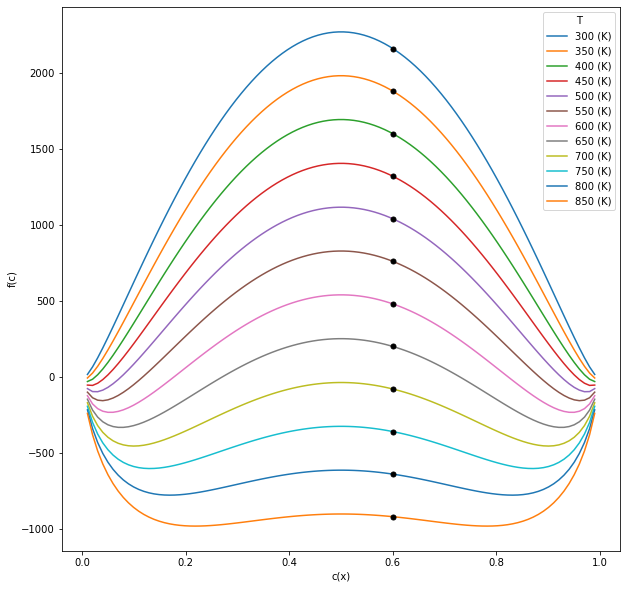

In [4]:
plot_density_vs_free_energy(c0=c.c0, T0=T_range, omega=c.omega, figsize=(10, 10))

## Visualization and Analysis

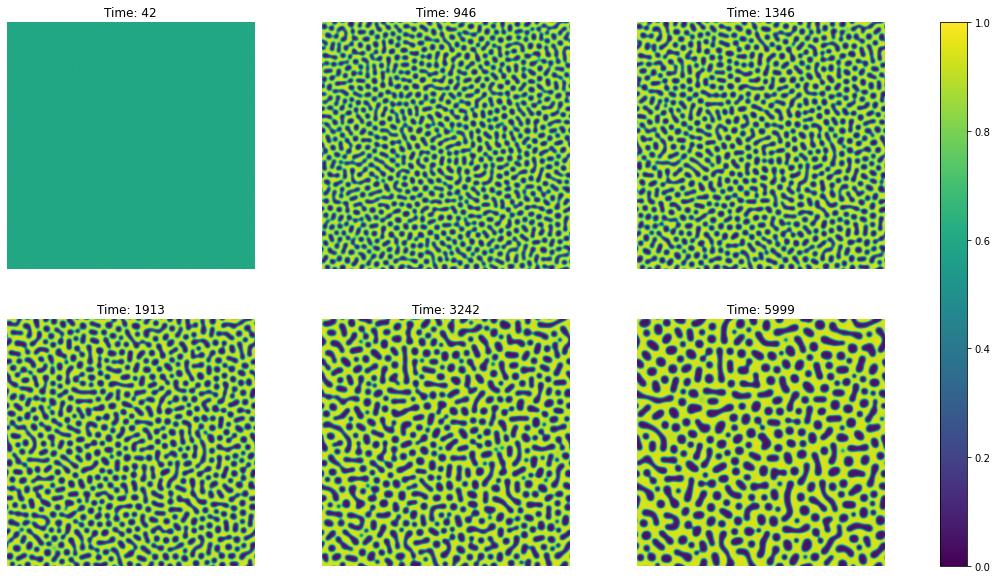

In [5]:
# Display samples from HD5.

simulation = "Cahn-Hilliard_(T=600,C=0.6).h5"

plot_field_grid(simulation, steps=[25, 60, 64, 68, 74, 81], nrows=2, ncols=3, figsize=(20, 10))

## Analysis 
Examples how to use `FFT_Analyser_2D` and `Domain_Analyser_2D` from `microtex.analysis` module to post-process simulation

In [6]:
# Display selected fields as grid.
spectras, fits, E = [], [], []

with HDF5Reader(simulation) as h5f:
    dset = h5f['fields']
    timesteps = dset.attrs['timesteps']
    dt = dset.attrs['dt']
    c = Configuration(T=dset.attrs['T'], dt=dt)
    fa = FFT_Analyser_2D(c)
    da = Domain_Analyser_2D(c)
    for ix, step in enumerate(timesteps):
        field = dset[ix]
        # spectral analysis
        fa.analyze_domain(field)
        gs, psd = fa.power_spectrum()
        popt, _ = fa.fit_gaussian()
        fits.append(popt)
        spectras.append(psd)
        # field analysis
        E.append(da.calculate_energy(field))

spectgram = np.array(spectras).T
fitarray = np.abs(np.array(fits))
Evol = np.array(E)

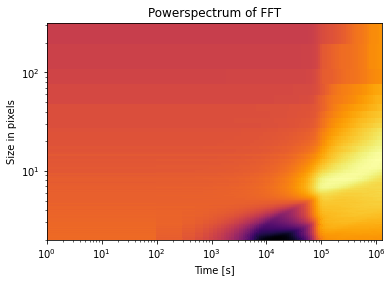

In [7]:
f, ax = plt.subplots()
xx, yy = np.meshgrid(timesteps * dt, gs)
h = ax.pcolor(xx, yy, np.log(spectgram), shading='nearest', cmap='inferno')
ax.set_xlim(left=1)
ax.set_yscale('log')
ax.set_xscale('log')
# plt.colorbar(h)
plt.xlabel('Time [s]')
plt.ylabel('Size in pixels')
plt.title('Powerspectrum of FFT');

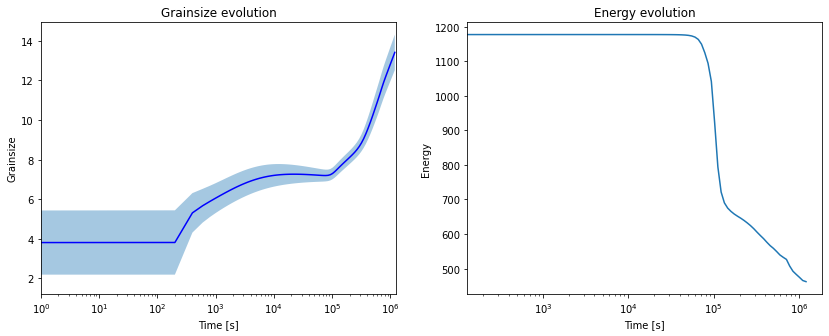

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(timesteps*dt, fitarray[:,1], 'b')
axs[0].fill_between(timesteps*dt,
                    fitarray[:,1] - fitarray[:,2],
                    fitarray[:,1] + fitarray[:,2], alpha=0.4)
axs[0].set_xlim(left=1)
axs[0].set_xscale('log')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Grainsize')
axs[0].set_title('Grainsize evolution')

axs[1].plot(timesteps*dt, Evol)
axs[1].set_xscale('log')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy evolution');